**Importing**

In [769]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("/content/drive/MyDrive/Competitions/KDAG/train.csv")
data

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
0,1,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,7981,5.5512,2018-01-01,77095,Texas,2018-01-01
1,2,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,6334,13.3650,2018-01-01,48185,Michigan,2018-01-01
2,3,Westland,0.0,14.730,3,Central,qexty,Consumer,shorts,Standard Class,6333,4.8609,2018-01-01,48185,Michigan,2018-01-01
3,4,Westland,0.0,43.920,3,Central,kariox,Consumer,television,Standard Class,6332,12.7368,2018-01-01,48185,Michigan,2018-01-01
4,5,Westland,0.0,66.580,2,Central,kariox,Consumer,laptop,Standard Class,6331,15.9792,2018-01-01,48185,Michigan,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,6696,Burlington,0.0,542.940,3,East,kariox,Consumer,battery,Standard Class,9389,152.0232,2021-01-01,5408,Vermont,2021-01-01
6696,6697,San Jose,0.2,276.784,2,West,kariox,Corporate,headset,Standard Class,9597,89.9548,2021-01-01,95123,California,2021-01-01
6697,6698,Burlington,0.0,2.040,1,East,kariox,Consumer,watch,Standard Class,9390,0.9588,2021-01-01,5408,Vermont,2021-01-01
6698,6699,New York City,0.1,207.846,3,East,qexty,Corporate,tshirts,Second Class,440,2.3094,2021-01-01,10024,New York,2021-01-01


**Creating Train Test set**

In [770]:
from sklearn.utils import shuffle
data = shuffle(data, random_state=69)

In [771]:
train = data.iloc[:4500,:]
test = data.iloc[4500:, :]
train,test

(        id departure city  ...  departure state  placement date
 3830  3831    Los Angeles  ...       California      2019-12-01
 504    505       Lakeland  ...          Florida      2018-05-01
 5780  5781     Manchester  ...      Connecticut      2020-10-01
 4548  4549  New York City  ...         New York      2020-04-01
 3873  3874        Clinton  ...         Maryland      2019-12-01
 ...    ...            ...  ...              ...             ...
 2742  2743     Louisville  ...         Kentucky      2019-07-01
 4451  4452       Gastonia  ...   North Carolina      2020-04-01
 2538  2539        Houston  ...            Texas      2019-05-01
 3294  3295        Seattle  ...       Washington      2019-10-01
 1796  1797   Philadelphia  ...     Pennsylvania      2018-12-01
 
 [4500 rows x 16 columns],
         id departure city  ...  departure state  placement date
 4774  4775           Yuma  ...          Arizona      2020-05-01
 2781  2782  New York City  ...         New York      2019-07

**Adding coeff to train**

In [772]:
train['coeff'] = train['profit']/train['price']
train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date,coeff
3830,3831,Los Angeles,0.0,50.000,2,West,fynota,Consumer,chocolates,Second Class,9376,10.5000,2019-12-01,90045,California,2019-12-01,0.2100
504,505,Lakeland,0.2,479.984,2,South,fynota,Consumer,fastfood,Second Class,7037,89.9970,2018-05-01,33801,Florida,2018-05-01,0.1875
5780,5781,Manchester,0.0,104.790,7,East,kariox,Corporate,laptop,Same Day,369,29.3412,2020-10-01,6040,Connecticut,2020-10-01,0.2800
4548,4549,New York City,0.0,20.700,2,East,kariox,Corporate,tablet,Standard Class,4090,9.9360,2020-04-01,10035,New York,2020-04-01,0.4800
3873,3874,Clinton,0.0,355.960,2,East,kariox,Home Office,battery,Standard Class,1095,103.2284,2019-12-01,20735,Maryland,2019-12-01,0.2900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2742,2743,Louisville,0.0,29.970,3,South,fynota,Consumer,colddrinks,Standard Class,6218,0.2997,2019-08-01,40214,Kentucky,2019-07-01,0.0100
4451,4452,Gastonia,0.2,291.960,5,South,fynota,Home Office,chocolates,Standard Class,432,54.7425,2020-04-01,28052,North Carolina,2020-04-01,0.1875
2538,2539,Houston,0.8,33.280,5,Central,kariox,Corporate,headset,Standard Class,4289,-49.9200,2019-05-01,77095,Texas,2019-05-01,-1.5000
3294,3295,Seattle,0.2,3.592,1,West,kariox,Corporate,headset,Standard Class,4275,1.1225,2019-10-01,98105,Washington,2019-10-01,0.3125


**Dropping useless columns from both**

In [773]:
train = train.drop(['departure city', 'no of items', 'segment', 'delivery type', 'RID', 'delivery date', 'address code', 'placement date'], axis=1)
test = test.drop(['departure city', 'no of items', 'segment', 'delivery type', 'RID', 'delivery date', 'address code', 'placement date'], axis=1)

**Integer Encoding Both based on train**

Here, test may get some null values 

In [774]:
discCol = ['location', 'class', 'sub-class', 'departure state']
for col in discCol:
  valDict = train[col].value_counts().to_dict()
  num=0
  for i in valDict:
    valDict[i] = num
    num+=1
  
  train[col] = train[col].map(valDict)
  test[col] = test[col].map(valDict)

**Creating State Index in train and propagating it to test**

Careful if test contains some states not in train

In [775]:
avgProfitState = train[['profit', 'departure state']].groupby('departure state').mean()

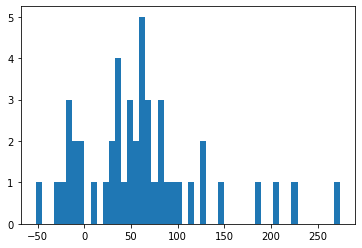

In [776]:
plt.hist(avgProfitState['profit'], bins=50)
plt.show()

Here limits are arbitrarily chosen

In [777]:
avgProfitStateDict = avgProfitState['profit'].to_dict()
for i in avgProfitStateDict:
  if(avgProfitStateDict[i]<0):
    avgProfitStateDict[i] = -1
  elif(avgProfitStateDict[i]>100):
    avgProfitStateDict[i] = 1
  else:
    avgProfitStateDict[i] = 0

In [778]:
train['stateIndex'] = train['departure state'].map(avgProfitStateDict)

In [779]:
test['stateIndex'] = test['departure state'].map(avgProfitStateDict)

In [780]:
train = train.drop('departure state', axis=1)
test = test.drop('departure state', axis=1)

**Checking for NULL**

Test might have some NULL

In [781]:
train.isnull().sum(), train.notnull().sum(), test.isnull().sum(), test.notnull().sum()

(id            0
 discount      0
 price         0
 location      0
 class         0
 sub-class     0
 profit        0
 coeff         0
 stateIndex    0
 dtype: int64, id            4500
 discount      4500
 price         4500
 location      4500
 class         4500
 sub-class     4500
 profit        4500
 coeff         4500
 stateIndex    4500
 dtype: int64, id            0
 discount      0
 price         0
 location      0
 class         0
 sub-class     0
 profit        0
 stateIndex    0
 dtype: int64, id            2200
 discount      2200
 price         2200
 location      2200
 class         2200
 sub-class     2200
 profit        2200
 stateIndex    2200
 dtype: int64)

**Model**

In [782]:
testIDS = test['id'].to_numpy()
Xtrain = train[['discount', 'price', 'location', 'class', 'sub-class', 'stateIndex']].to_numpy()
ytrain = train['coeff'].to_numpy()
ztrain = train['profit'].to_numpy()
Xtest = test[['discount', 'price', 'location', 'class', 'sub-class', 'stateIndex']].to_numpy()
ytest = (test['profit']/test['price']).to_numpy()
ztest = test['profit'].to_numpy()

In [783]:
from sklearn.preprocessing import StandardScaler
scl1 = StandardScaler()
XtrainScaled = scl1.fit_transform(Xtrain)
XtestScaled = scl1.transform(Xtest)

# **Dtree**

In [784]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=9, min_samples_leaf=10)

from sklearn.model_selection import cross_validate
cv = cross_validate(dtr, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.95615698, 0.95527861, 0.95757422, 0.95713172]),
 array([0.9430335 , 0.95216958, 0.9465791 , 0.94432146]))

In [785]:
dtr.fit(XtrainScaled, ytrain)
ypreds = dtr.predict(XtestScaled)

In [786]:
from sklearn.metrics import r2_score
print(r2_score(ytest, ypreds))

0.9477142053412161


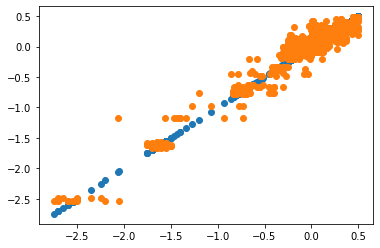

In [787]:
plt.scatter(ytest,ytest)
plt.scatter(ytest, ypreds)

In [788]:
X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [789]:
lr.fit(X2train, ztrain)

X2test = (ypreds*Xtest[:,1]).reshape(-1,1)
zpreds = lr.predict(X2test)

In [790]:
print(r2_score(ztest, zpreds))

0.1154939820811628


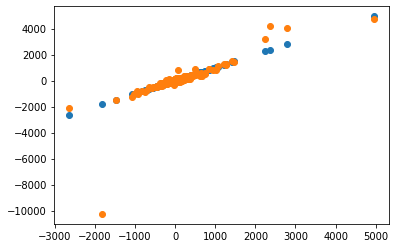

In [791]:
plt.scatter(ztest,ztest)
plt.scatter(ztest, zpreds)

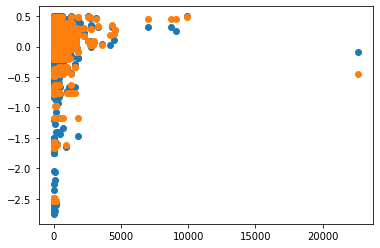

In [792]:
#plt.scatter(X2test, zpreds)
plt.scatter((Xtest[:,1].reshape(-1,1)), ytest)
plt.scatter((Xtest[:,1].reshape(-1,1)), ypreds)

# **SVM**

In [793]:
from sklearn.svm import SVR
svr = SVR(C=15)

from sklearn.model_selection import cross_validate
cv = cross_validate(svr, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.95110632, 0.94923319, 0.9540059 , 0.95282326]),
 array([0.93168239, 0.94675061, 0.93467269, 0.93868004]))

In [794]:
svr.fit(XtrainScaled, ytrain)
ypreds = svr.predict(XtestScaled)

In [795]:
from sklearn.metrics import r2_score
print(r2_score(ytest, ypreds))

0.9384706023585956


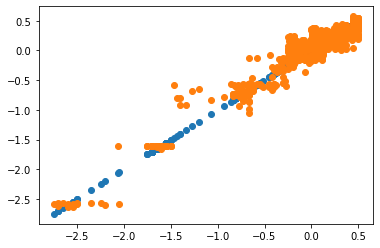

In [796]:
plt.scatter(ytest,ytest)
plt.scatter(ytest, ypreds)

In [797]:
X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [798]:
lr.fit(X2train, ztrain)

X2test = (ypreds*Xtest[:,1]).reshape(-1,1)
zpreds = lr.predict(X2test)

In [799]:
print(r2_score(ztest, zpreds))

0.5985893364617652


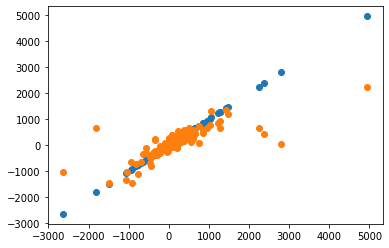

In [800]:
plt.scatter(ztest,ztest)
plt.scatter(ztest, zpreds)

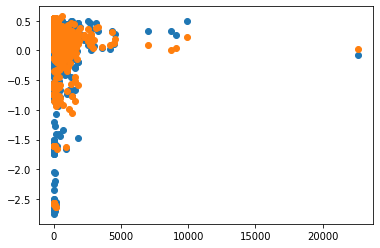

In [801]:
#plt.scatter(X2test, zpreds)
plt.scatter((Xtest[:,1].reshape(-1,1)), ytest)
plt.scatter((Xtest[:,1].reshape(-1,1)), ypreds)

# **Voting**

In [802]:
from sklearn.ensemble import VotingRegressor
ada = VotingRegressor(estimators=[('svr', svr), ('dtr', dtr)])

from sklearn.model_selection import cross_validate
cv = cross_validate(ada, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.95901952, 0.95766592, 0.96086954, 0.96007407]),
 array([0.9461164 , 0.95594963, 0.94696583, 0.94686906]))

In [803]:
ada.fit(XtrainScaled, ytrain)
ypreds = ada.predict(XtestScaled)

In [804]:
from sklearn.metrics import r2_score
print(r2_score(ytest, ypreds))

0.948758095636885


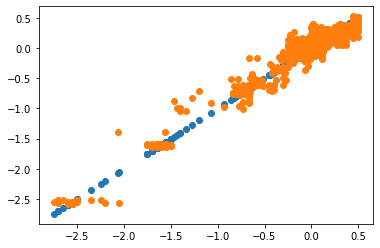

In [805]:
plt.scatter(ytest,ytest)
plt.scatter(ytest, ypreds)

In [806]:
from sklearn.model_selection import cross_val_predict

y2trainpreds = ada.predict(XtrainScaled)

In [807]:
X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [808]:
lr.fit(X2train, ztrain)

X2test = (ypreds*Xtest[:,1]).reshape(-1,1)
zpreds = lr.predict(X2test)

In [809]:
print(r2_score(ztest, zpreds))

0.8157652287898687


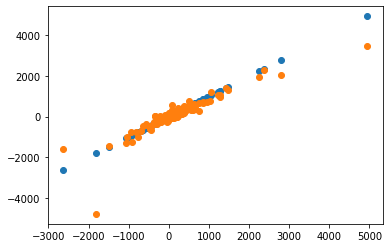

In [810]:
plt.scatter(ztest,ztest)
plt.scatter(ztest, zpreds)

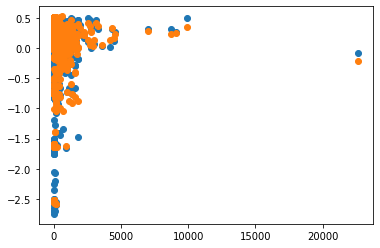

In [811]:
#plt.scatter(X2test, zpreds)
plt.scatter((Xtest[:,1].reshape(-1,1)), ytest)
plt.scatter((Xtest[:,1].reshape(-1,1)), ypreds)

# **Poly Reg**

In [812]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
XtrainScaledpoly = poly.fit_transform(XtrainScaled)
lrpol = LinearRegression()

from sklearn.model_selection import cross_validate
cv = cross_validate(lrpol, XtrainScaledpoly, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.90353694, 0.89932378, 0.9064345 , 0.90581373]),
 array([0.90214434, 0.91334073, 0.87960113, 0.89420547]))

In [813]:
lrpol.fit(XtrainScaledpoly, ytrain)
XtestScaledpoly = poly.transform(XtestScaled)
ypreds = lrpol.predict(XtestScaledpoly)

In [814]:
from sklearn.metrics import r2_score
print(r2_score(ytest, ypreds))

0.9009330890749079


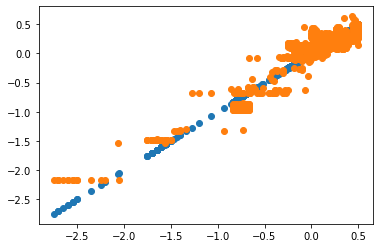

In [815]:
plt.scatter(ytest,ytest)
plt.scatter(ytest, ypreds)

In [816]:
X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [817]:
lr.fit(X2train, ztrain)

X2test = (ypreds*Xtest[:,1]).reshape(-1,1)
zpreds = lr.predict(X2test)

In [818]:
print(r2_score(ztest, zpreds))

-0.8104873534486898


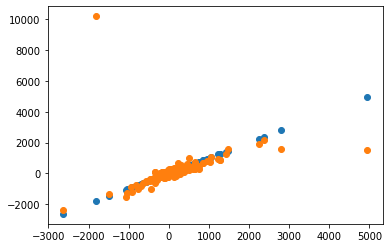

In [819]:
plt.scatter(ztest,ztest)
plt.scatter(ztest, zpreds)

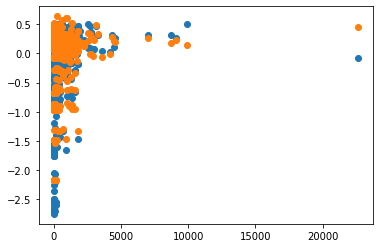

In [820]:
#plt.scatter(X2test, zpreds)
plt.scatter((Xtest[:,1].reshape(-1,1)), ytest)
plt.scatter((Xtest[:,1].reshape(-1,1)), ypreds)

# **KNN**

In [822]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=30, weights='distance')

from sklearn.model_selection import cross_validate
cv = cross_validate(knn, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.99983261, 0.99969587, 0.99972202, 0.99988413]),
 array([0.92916057, 0.95104178, 0.94254439, 0.94698689]))

In [823]:
knn.fit(XtrainScaled, ytrain)
ypreds = knn.predict(XtestScaled)

In [824]:
from sklearn.metrics import r2_score
print(r2_score(ytest, ypreds))

0.9385103232290843


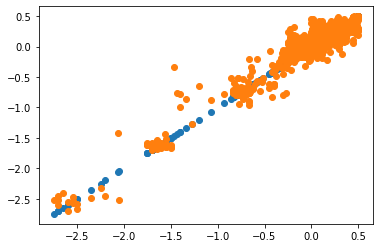

In [825]:
plt.scatter(ytest,ytest)
plt.scatter(ytest, ypreds)

In [826]:
X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [827]:
lr.fit(X2train, ztrain)

X2test = (ypreds*Xtest[:,1]).reshape(-1,1)
zpreds = lr.predict(X2test)

In [828]:
print(r2_score(ztest, zpreds))

0.37731811315586306


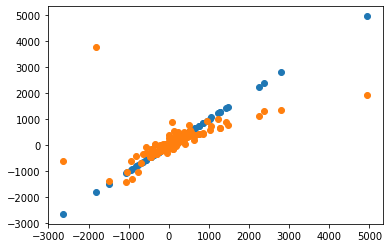

In [829]:
plt.scatter(ztest,ztest)
plt.scatter(ztest, zpreds)

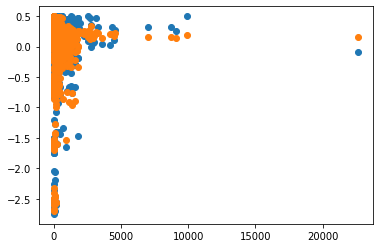

In [830]:
#plt.scatter(X2test, zpreds)
plt.scatter((Xtest[:,1].reshape(-1,1)), ytest)
plt.scatter((Xtest[:,1].reshape(-1,1)), ypreds)

# XGBoost

In [840]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

from sklearn.model_selection import cross_validate
cv = cross_validate(xgb, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.95855484, 0.95623435, 0.95958356, 0.95953966]),
 array([0.95155778, 0.9589356 , 0.94833029, 0.95000114]))

In [841]:
xgb.fit(XtrainScaled, ytrain)
ypreds = xgb.predict(XtestScaled)

[17:16:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [842]:
from sklearn.metrics import r2_score
print(r2_score(ytest, ypreds))

0.9512840854575683


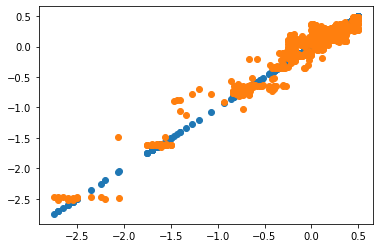

In [843]:
plt.scatter(ytest,ytest)
plt.scatter(ytest, ypreds)

In [844]:
X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [845]:
lr.fit(X2train, ztrain)

X2test = (ypreds*Xtest[:,1]).reshape(-1,1)
zpreds = lr.predict(X2test)

In [846]:
print(r2_score(ztest, zpreds))

0.5460302715740322


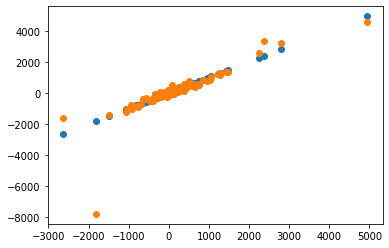

In [847]:
plt.scatter(ztest,ztest)
plt.scatter(ztest, zpreds)

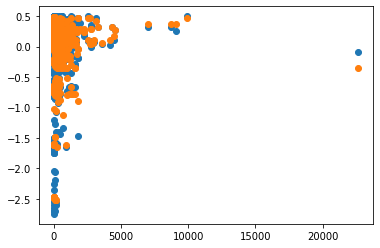

In [848]:
#plt.scatter(X2test, zpreds)
plt.scatter((Xtest[:,1].reshape(-1,1)), ytest)
plt.scatter((Xtest[:,1].reshape(-1,1)), ypreds)

# Neural Network

In [897]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=(50,50,50,50,50,50,50))

from sklearn.model_selection import cross_validate
cv = cross_validate(nn, XtrainScaledpoly, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.95447523, 0.95686435, 0.95951629, 0.95854218]),
 array([0.9379417 , 0.95378475, 0.94202863, 0.94074843]))

In [898]:
nn.fit(XtrainScaled, ytrain)
ypreds = nn.predict(XtestScaled)

In [899]:
from sklearn.metrics import r2_score
print(r2_score(ytest, ypreds))

0.9424590103592665


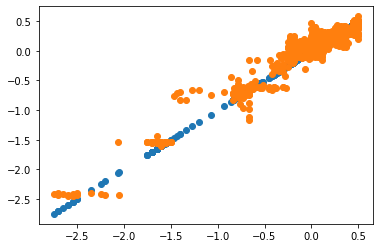

In [900]:
plt.scatter(ytest,ytest)
plt.scatter(ytest, ypreds)

In [901]:
X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [902]:
lr.fit(X2train, ztrain)

X2test = (ypreds*Xtest[:,1]).reshape(-1,1)
zpreds = lr.predict(X2test)

In [903]:
print(r2_score(ztest, zpreds))

0.459838645791394


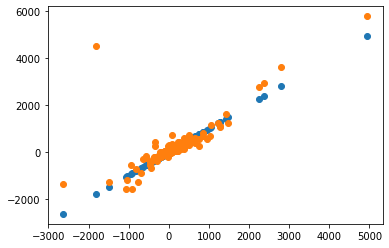

In [904]:
plt.scatter(ztest,ztest)
plt.scatter(ztest, zpreds)

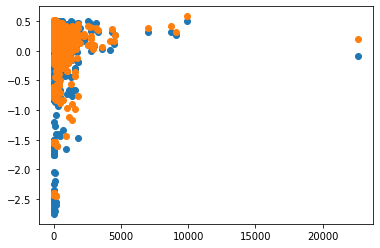

In [905]:
#plt.scatter(X2test, zpreds)
plt.scatter((Xtest[:,1].reshape(-1,1)), ytest)
plt.scatter((Xtest[:,1].reshape(-1,1)), ypreds)

**Pipeline**

In [981]:
from sklearn.pipeline import Pipeline
polypipe = PolynomialFeatures(degree=2)
sclpipe = StandardScaler()
nnpipe = MLPRegressor(hidden_layer_sizes=(50,50,50,50,50,50,50))

pipe = [('poly', polypipe),('nn', nnpipe)]
nnPipeline = Pipeline(pipe)

In [982]:
cv = cross_validate(nnPipeline, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.95586917, 0.95140056, 0.95869018, 0.96018656]),
 array([0.9406732 , 0.94550993, 0.9422254 , 0.94508711]))

In [983]:
nnPipeline.fit(XtrainScaled, ytrain)
ypreds = nnPipeline.predict(XtestScaled)

In [984]:
from sklearn.metrics import r2_score
print(r2_score(ytest, ypreds))

0.9434676680032648


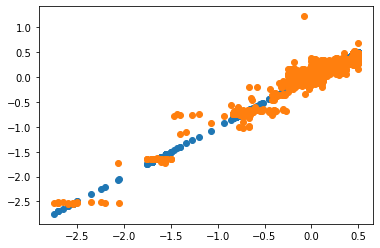

In [985]:
plt.scatter(ytest,ytest)
plt.scatter(ytest, ypreds)

In [986]:
X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [987]:
lr.fit(X2train, ztrain)

X2test = (ypreds*Xtest[:,1]).reshape(-1,1)
zpreds = lr.predict(X2test)

In [988]:
print(r2_score(ztest, zpreds))

-8.695537606185288


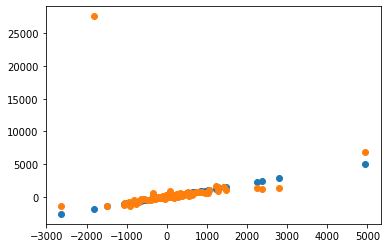

In [989]:
plt.scatter(ztest,ztest)
plt.scatter(ztest, zpreds)

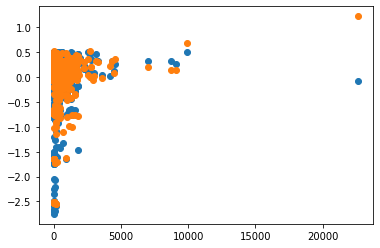

In [990]:
#plt.scatter(X2test, zpreds)
plt.scatter((Xtest[:,1].reshape(-1,1)), ytest)
plt.scatter((Xtest[:,1].reshape(-1,1)), ypreds)

# Stacking

In [965]:
from sklearn.ensemble import StackingRegressor
stack = StackingRegressor([('xgb', xgb),('svm', svr),('knn', knn),('vot', ada),('nn', nnPipeline)])

from sklearn.model_selection import cross_validate
cv = cross_validate(stack, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.97498793, 0.97096755, 0.97462305, 0.97007098]),
 array([0.95049072, 0.96040065, 0.95051024, 0.95183329]))

In [966]:
stack.fit(XtrainScaled, ytrain)
ypreds = stack.predict(XtestScaled)

[18:12:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:12:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:12:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:12:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:12:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:12:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [974]:
from sklearn.metrics import r2_score
print(r2_score(ytest, ypreds))

0.9514823016208535


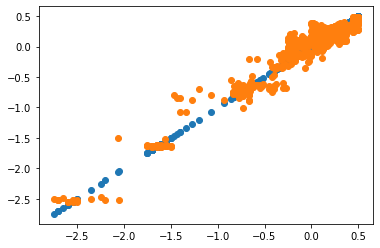

In [975]:
plt.scatter(ytest,ytest)
plt.scatter(ytest, ypreds)

In [976]:
X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [977]:
lr.fit(X2train, ztrain)

X2test = (ypreds*Xtest[:,1]).reshape(-1,1)
zpreds = lr.predict(X2test)

In [978]:
print(r2_score(ztest, zpreds))

0.9108901277627033


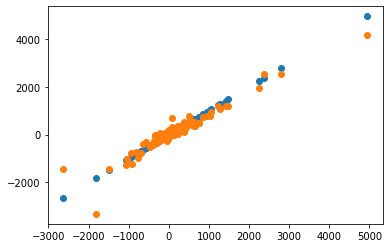

In [979]:
plt.scatter(ztest,ztest)
plt.scatter(ztest, zpreds)

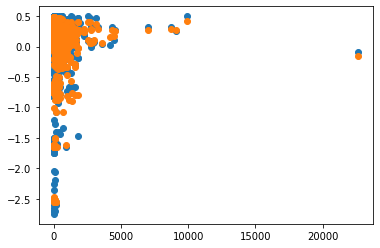

In [980]:
#plt.scatter(X2test, zpreds)
plt.scatter((Xtest[:,1].reshape(-1,1)), ytest)
plt.scatter((Xtest[:,1].reshape(-1,1)), ypreds)

# GridSearch

Selected model: xgb, svr, knn, voting, nn

**SVR**

In [993]:
from sklearn.model_selection import GridSearchCV
svr_param = {'C':[0.1, 0.5, 1, 5,10,15,20], 'gamma':('scale', 'auto')}

gsearchSVR = GridSearchCV(SVR(kernel='rbf'), svr_param)

In [994]:
gsearchSVR.fit(XtrainScaled, ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 15, 20],
                         'gamma': ('scale', 'auto')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [995]:
gsearchSVR.best_params_

{'C': 15, 'gamma': 'auto'}

In [997]:
svr_param = {'C':[15,16,17,18,19,20]}

gsearchSVR = GridSearchCV(SVR(kernel='rbf', gamma='auto'), svr_param)
gsearchSVR.fit(XtrainScaled, ytrain)
gsearchSVR.best_params_

{'C': 17}

In [998]:
cv = cross_validate(SVR(kernel='rbf', gamma='auto', C=17), XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.951246  , 0.94933041, 0.9539713 , 0.95305965]),
 array([0.93152545, 0.94663227, 0.93441735, 0.93861008]))

**DTree**

In [1004]:
dtree_param = {'criterion':['mse', 'friedman_mse', 'mae', 'poisson'], 'splitter':['best', 'random'], 'max_depth': [1,5,9,10,15,20,25], 'min_samples_leaf':[5,10,20,50]}

gsearchDTR = GridSearchCV(DecisionTreeRegressor(), dtree_param, n_jobs=-1)

In [1007]:
gsearchDTR.fit(XtrainScaled, ytrain)
gsearchDTR.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 20,
 'min_samples_leaf': 5,
 'splitter': 'random'}

In [1008]:
dtree_param = {'max_depth': [17,18,19,20,21,21,23], 'min_samples_leaf':[2,3,4,5,6,7,8]}

gsearchDTR = GridSearchCV(DecisionTreeRegressor(criterion='friedman_mse', splitter='random'), dtree_param, n_jobs=-1)

In [1009]:
gsearchDTR.fit(XtrainScaled, ytrain)
gsearchDTR.best_params_

{'max_depth': 21, 'min_samples_leaf': 4}

In [1011]:
cv = cross_validate(DecisionTreeRegressor(criterion='friedman_mse', splitter='random' ,max_depth=21, min_samples_leaf=4), XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.96108425, 0.95796069, 0.96259744, 0.95832365]),
 array([0.94778541, 0.95891733, 0.94927305, 0.94295233]))

**KNN**

In [1019]:
knn_param = {'n_neighbors':[2,5,10,20,30,40,80,100], 'weights':['uniform', 'distance']}

gsearchKNN = GridSearchCV(KNeighborsRegressor(), knn_param, n_jobs=-1)

In [1020]:
gsearchKNN.fit(XtrainScaled, ytrain)
gsearchKNN.best_params_

{'n_neighbors': 20, 'weights': 'distance'}

In [1021]:
knn_param = {'n_neighbors':[10,11,12,13,14,15,17,18,19,20,21,22,23,25,30]}

gsearchKNN = GridSearchCV(KNeighborsRegressor(weights='distance'), knn_param, n_jobs=-1)

In [1022]:
gsearchKNN.fit(XtrainScaled, ytrain)
gsearchKNN.best_params_

{'n_neighbors': 15}

In [1023]:
cv = cross_validate(KNeighborsRegressor(weights='distance', n_neighbors=15), XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.99983261, 0.99969587, 0.99972202, 0.99988413]),
 array([0.93347498, 0.95154036, 0.94347592, 0.94783253]))

**NN**

In [1036]:
polypipe = PolynomialFeatures(degree=2)
nnpipe = MLPRegressor()

pipe = [('poly', polypipe),('nn', nnpipe)]
nnPipeline = Pipeline(pipe)

In [1042]:
nn_param = {
    'nn__hidden_layer_sizes': [(50,50,50), (50,50,50,50,50,50,50), (100,), (50,50,50,50,50)],
    'nn__activation': ['tanh', 'relu'],
    'nn__solver': ['sgd', 'adam'],
    'nn__alpha': [0.0001, 0.05],
    'nn__learning_rate': ['constant','adaptive'],
}

gsearchNN = GridSearchCV(nnPipeline, nn_param, n_jobs=-1, verbose=1)

In [1043]:
gsearchNN.fit(XtrainScaled, ytrain)
gsearchNN.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 15.5min finished


{'nn__activation': 'relu',
 'nn__alpha': 0.0001,
 'nn__hidden_layer_sizes': (50, 50, 50, 50, 50, 50, 50),
 'nn__learning_rate': 'constant',
 'nn__solver': 'adam'}

In [1044]:
nn_param = {
    'nn__hidden_layer_sizes': [(50,50,50,50,50,50), (50,50,50,50,50,50,50), (50,50,50,50,50,50,50,50), (40,40,40,40,40,40,40,40), (60,60,60,60,60,60)],
          }

gsearchNN = GridSearchCV(nnPipeline, nn_param, n_jobs=-1, verbose=1)

In [1045]:
gsearchNN.fit(XtrainScaled, ytrain)
gsearchNN.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   38.8s finished


{'nn__hidden_layer_sizes': (50, 50, 50, 50, 50, 50, 50)}

# Final Stacking

In [1078]:
svr = SVR(kernel='rbf', gamma='auto', C=17)
dtr = DecisionTreeRegressor(max_depth=9, min_samples_leaf=10)
vot = VotingRegressor(estimators=[('svr', svr), ('dtr', dtr)])
knn = KNeighborsRegressor(weights='distance', n_neighbors=30)
xgb = XGBRegressor()

#nn pipeline
polypipe = PolynomialFeatures(degree=2)
sclpipe = StandardScaler()
nnpipe = MLPRegressor(hidden_layer_sizes=(50,50,50,50,50,50,50))

pipe = [('poly', polypipe),('nn', nnpipe)]
nnPipeline = Pipeline(pipe)

In [1079]:
stack = StackingRegressor([('xgb', xgb),('svm', svr),('knn', knn),('vot', vot),('nn', nnPipeline)])

cv = cross_validate(stack, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.97527655, 0.97084153, 0.97498165, 0.97053377]),
 array([0.95007266, 0.96072043, 0.95073738, 0.95176843]))

In [1080]:
stack.fit(XtrainScaled, ytrain)
ypreds = stack.predict(XtestScaled)

[20:00:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:01:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:01:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:01:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:01:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:01:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [1081]:
from sklearn.metrics import r2_score
print(r2_score(ytest, ypreds))

0.9512848001876772


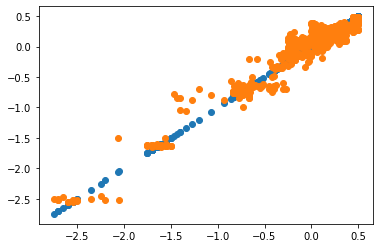

In [1082]:
plt.scatter(ytest,ytest)
plt.scatter(ytest, ypreds)

In [1083]:
X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [1084]:
lr.fit(X2train, ztrain)

X2test = (ypreds*Xtest[:,1]).reshape(-1,1)
zpreds = lr.predict(X2test)

In [1085]:
print(r2_score(ztest, zpreds))

0.8723524881889827


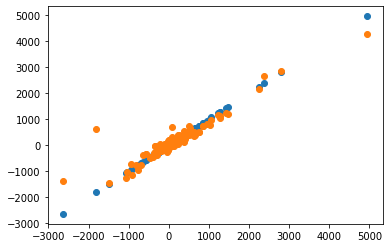

In [1086]:
plt.scatter(ztest,ztest)
plt.scatter(ztest, zpreds)

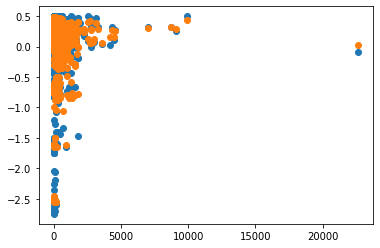

In [1087]:
#plt.scatter(X2test, zpreds)
plt.scatter((Xtest[:,1].reshape(-1,1)), ytest)
plt.scatter((Xtest[:,1].reshape(-1,1)), ypreds)